In [123]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras import backend as K
import keras_tuner as kt
from keras_tuner import GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import TimeSeriesSplit

In [124]:
num_threads = 16
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_threads,
                                  inter_op_parallelism_threads=num_threads)
session = tf.compat.v1.Session(config=config)
K.set_session(session)

In [125]:
def load_data(file_path):
    # Load input data
    input_data = pd.read_csv(file_path, sep=",")

    # Convert "Datum" column to datetime and set it as the index
    input_data = input_data.set_index(pd.to_datetime(input_data["Datum"], dayfirst=True))

    # Select the features to use for training and testing
    input_data = input_data[["SECCI", "Temperatur", "Salinität", "NO2", "NO3"]]
    return input_data

In [126]:

def add_fourier_terms(data, period, num_terms):
    temp_data = data.copy()
    for i in range(1, num_terms + 1):
        temp_data[f"sin_{i}"] = np.sin(2 * np.pi * i * data.index.dayofyear / period)
        temp_data[f"cos_{i}"] = np.cos(2 * np.pi * i * data.index.dayofyear / period)
    return temp_data

In [127]:

def scale_data(train_data):
    # Scale the data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    return train_data_scaled,  scaler

In [128]:
# Define the LSTM model
def define_model(input_shape):
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=256, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.8))
    model.add(LSTM(units=128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.6))
    model.add(LSTM(units=128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=5, activation='linear'))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    return model

In [129]:
def prepare_data(train_data):
    # Separate features and target variables
    train_x = train_data[:, :train_data.shape[1]]
    train_y = train_data[:, :5]

    # Reshape data for LSTM model
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

    return train_x, train_y

In [130]:
def train_model(model, train_x, train_y):
    # Define the callbacks
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
    checkpoint = ModelCheckpoint("best_model.h5", monitor='loss', verbose=0, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=0, mode='min', min_delta=0.0001)

    # Train the model
    history = model.fit(train_x, train_y, epochs=100, batch_size=32, callbacks=[early_stop, checkpoint, reduce_lr])
    return history

In [131]:
def predict(model, x_data, scaler, y_data):
    # Predict using the trained model
    y_pred = model.predict(x_data)

    # Scale back the predicted data
    y_pred_scaled_back = scaler.inverse_transform(np.squeeze(np.concatenate((y_pred, y_data[:, 5:]), axis=1)))[:, :5]

    return y_pred_scaled_back

In [132]:

def plot_predicted_actual(y_true, y_pred):
    # Plot the predicted and actual values for each column
    col_names = ["SECCI", "Temperatur", "Salinität", "NO2", "NO3"]
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(col_names):
        plt.plot(y_true.index, y_pred[:, i], label=f"{col}")
    plt.legend()
    plt.show()

In [133]:
"""def tune_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Choice('units_1', values=[256]), activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp.Choice('dropout_1', values=[0.8])))
    model.add(LSTM(units=hp.Choice('units_2', values=[128]), activation='tanh', return_sequences=True))
    model.add(Dropout(hp.Choice('dropout_2', values=[0.6, 0.7])))
    model.add(LSTM(units=hp.Choice('units_3', values=[128]), activation='tanh'))
    model.add(Dropout(hp.Choice('dropout_3', values=[0.5, 0.6])))
    model.add(Dense(units=5, activation='linear'))
    model.compile(optimizer=hp.Choice("optimizer", values=["RMSprop", "Adam"]), loss='mean_squared_error')
    return model"""

'def tune_model(hp):\n    model = Sequential()\n    model.add(LSTM(units=hp.Choice(\'units_1\', values=[256]), activation=\'tanh\', return_sequences=True, input_shape=input_shape))\n    model.add(Dropout(hp.Choice(\'dropout_1\', values=[0.8])))\n    model.add(LSTM(units=hp.Choice(\'units_2\', values=[128]), activation=\'tanh\', return_sequences=True))\n    model.add(Dropout(hp.Choice(\'dropout_2\', values=[0.6, 0.7])))\n    model.add(LSTM(units=hp.Choice(\'units_3\', values=[128]), activation=\'tanh\'))\n    model.add(Dropout(hp.Choice(\'dropout_3\', values=[0.5, 0.6])))\n    model.add(Dense(units=5, activation=\'linear\'))\n    model.compile(optimizer=hp.Choice("optimizer", values=["RMSprop", "Adam"]), loss=\'mean_squared_error\')\n    return model'

In [134]:
"""def tune_lstm_model_with_keras_tuner_cross_val(train_data_scaled, input_shape, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    tuner = GridSearch(
        tune_model,  # the function that defines the model to be tuned
        objective='val_loss',
        max_trials=5,  # the number of combinations of hyperparameters to try
        executions_per_trial=2,  # the number of times to train each combination of hyperparameters
        directory='tuner_results',  # the directory to store the results
        project_name='lstm_tuning')  # the name of the project

    for train_index, val_index in tscv.split(train_data_scaled):
        train_data_scaled_train = train_data_scaled[train_index]
        train_data_scaled_val = train_data_scaled[val_index]

        # Prepare the data for training
        train_x, train_y = prepare_data(train_data_scaled_train)
        val_x, val_y = prepare_data(train_data_scaled_val)

        # Start the hyperparameter search
        tuner.search(
            train_x, train_y,
            epochs=100,
            batch_size=64,
            validation_data=(val_x, val_y),
            callbacks=[EarlyStopping(patience=5, verbose=0),
                       ModelCheckpoint('best_model.h5', save_best_only=True, verbose=0),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='min', min_delta=0.0001)]
        )


    # Get the best model and its hyperparameters
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters()[0]

    return best_model, best_hyperparameters"""



"def tune_lstm_model_with_keras_tuner_cross_val(train_data_scaled, input_shape, n_splits=5):\n    tscv = TimeSeriesSplit(n_splits=n_splits)\n\n    tuner = GridSearch(\n        tune_model,  # the function that defines the model to be tuned\n        objective='val_loss',\n        max_trials=5,  # the number of combinations of hyperparameters to try\n        executions_per_trial=2,  # the number of times to train each combination of hyperparameters\n        directory='tuner_results',  # the directory to store the results\n        project_name='lstm_tuning')  # the name of the project\n\n    for train_index, val_index in tscv.split(train_data_scaled):\n        train_data_scaled_train = train_data_scaled[train_index]\n        train_data_scaled_val = train_data_scaled[val_index]\n\n        # Prepare the data for training\n        train_x, train_y = prepare_data(train_data_scaled_train)\n        val_x, val_y = prepare_data(train_data_scaled_val)\n\n        # Start the hyperparameter search\n 

In [135]:
# Example usage:
input_data = load_data("df_cleaned_both_directions_interpolated.csv")
train_data = input_data.loc['1968-01-09':'2003-12-31']
train_data_with_fourier = add_fourier_terms(train_data, 365, 8)
train_data_scaled, scaler = scale_data(train_data_with_fourier)

In [136]:

model = define_model(input_shape=(train_data_scaled.shape[1], 1))
train_x, train_y = prepare_data(train_data_scaled)
history = train_model(model, train_x, train_y,)


Epoch 1/100
411/411 [==============================] - 28s 56ms/step - loss: 0.4838 - lr: 0.0010
Epoch 2/100
411/411 [==============================] - 23s 56ms/step - loss: 0.2937 - lr: 0.0010
Epoch 3/100
411/411 [==============================] - 23s 57ms/step - loss: 0.2216 - lr: 0.0010
Epoch 4/100
411/411 [==============================] - 23s 56ms/step - loss: 0.1774 - lr: 0.0010
Epoch 5/100
411/411 [==============================] - 23s 56ms/step - loss: 0.1547 - lr: 0.0010
Epoch 6/100
411/411 [==============================] - 23s 56ms/step - loss: 0.1391 - lr: 0.0010
Epoch 7/100
411/411 [==============================] - 23s 56ms/step - loss: 0.1280 - lr: 0.0010
Epoch 8/100
411/411 [==============================] - 23s 56ms/step - loss: 0.1134 - lr: 0.0010
Epoch 9/100
411/411 [==============================] - 23s 56ms/step - loss: 0.0989 - lr: 0.0010
Epoch 10/100
411/411 [==============================] - 23s 57ms/step - loss: 0.0888 - lr: 0.0010
Epoch 11/100
411/411 [=======

12/12 [==============================] - 1s 25ms/step
               SECCI  Temperatur  Salinität       NO2       NO3
2004-01-01  3.997754    5.409855  33.621183  2.667655  8.923724
2004-01-02  4.070246    5.267356  33.600139  2.608179  9.779877
2004-01-03  3.885724    5.350728  33.664896  2.626743  9.080065
2004-01-04  3.122553    5.051978  33.629416  2.583077  8.373113
2004-01-05  2.356215    4.771153  33.583041  2.533759  7.753776
...              ...         ...        ...       ...       ...
2004-12-26  1.157644    7.132883  31.358718  1.939653  8.768462
2004-12-27  1.197616    7.157233  31.355360  2.013647  9.220631
2004-12-28  1.237718    7.182679  31.352015  2.087616  9.682324
2004-12-29  1.507032    7.044976  31.409471  2.271915  7.574832
2004-12-30  1.503280    7.069032  31.404087  2.278677  7.600285

[365 rows x 5 columns]


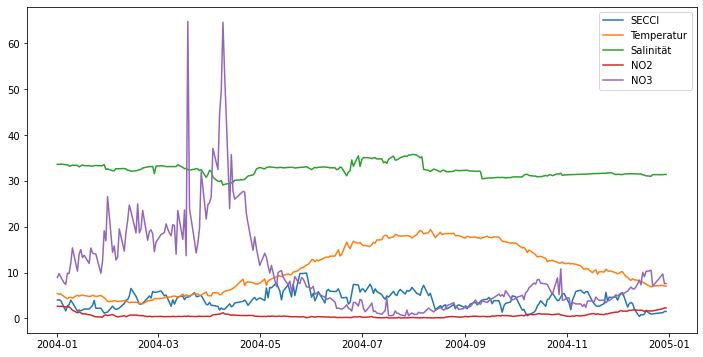

SECCI          4.076031
Temperatur    10.829082
Salinität     32.347971
NO2            0.655522
NO3           10.067303
dtype: float64

In [137]:

# Vorhersage für die nächsten 365 Tage
future_dates = pd.date_range(start=train_data.index[-1] + pd.DateOffset(days=1), periods=365, freq="D")
future_data = pd.DataFrame(index=future_dates, columns=train_data_with_fourier.columns)
future_data.iloc[:, :5] = train_data.iloc[-365:, :5]  # Verwenden Sie die letzten 365 Tage der ursprünglichen Trainingsdaten (unskaliert)
future_data_with_fourier = add_fourier_terms(future_data, 365, 8)  # Passen Sie die Anzahl der Fourier-Terme entsprechend an (4 oder 8)
future_data_scaled = scaler.transform(future_data_with_fourier)
future_x = future_data_scaled[:, :train_data_scaled.shape[1]]
future_x = np.reshape(future_x, (future_x.shape[0], future_x.shape[1], 1))
future_y_pred = predict(model, future_x, scaler, future_data_scaled)
predicted_df = pd.DataFrame(future_y_pred, columns=["SECCI", "Temperatur", "Salinität", "NO2", "NO3"], index=future_dates)
predicted_df["NO3"][predicted_df["NO3"] < 0] = 0
print(predicted_df)
plot_predicted_actual(predicted_df, future_y_pred)
predicted_df.mean()


In [138]:
predicted_df.to_csv("predicted_data2004_2.csv", index=True)
